#Objective:
A machine learning project that detects the presence of diseases in plants using image data. The model analyzes leaf images to classify whether a plant is healthy or affected by a specific disease, helping support early detection and agricultural health monitoring.

#Column Details:
* **temperature:** Measured in degrees Celsius
* **humidity**: Measured as percentage
* **rainfall**: Measured in millimeters
* **soil_pH**: Acidity/alkalinity measurement
* **disease_present**: Binary label (0 = healthy, 1 = diseased)


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Loading the dataset
data = pd.read_csv("/content/plant_disease_dataset.csv")
data.head()

,temperature,humidity,rainfall,soil_pH,disease_present
0,27.483571,33.215053,0.572758,4.975875,1
1,24.308678,36.945005,42.522346,8.165266,0
2,28.238443,34.026189,16.095303,6.316734,1
3,32.615149,41.104180,20.311015,6.164949,0
4,23.829233,51.971785,11.851323,8.482468,0


In [3]:
data.tail()

,temperature,humidity,rainfall,soil_pH,disease_present
9995,31.505510,81.939137,22.406822,5.862952,1
9996,15.008275,86.886833,10.503881,4.070539,0
9997,21.473416,81.891770,13.426869,7.101583,0
9998,27.478828,88.567649,9.719659,7.732620,0
9999,28.221942,71.900401,4.886391,4.383536,0


In [4]:
data.shape

(10000, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      10000 non-null  float64
 1   humidity         10000 non-null  float64
 2   rainfall         10000 non-null  float64
 3   soil_pH          10000 non-null  float64
 4   disease_present  10000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,10000.0,25.612191,5.813841,5.387999,21.815610,25.293238,28.916048,56.686495
humidity,10000.0,62.119300,22.679977,6.244209,40.772925,72.211752,81.032999,102.395421
rainfall,10000.0,9.807522,9.852130,0.000055,2.812822,6.864898,13.442871,84.654161
soil_pH,10000.0,6.245855,1.302465,4.000075,5.122970,6.232188,7.386377,8.499875
disease_present,10000.0,0.241000,0.427712,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
data.isnull().sum()

,0
temperature,0
humidity,0
rainfall,0
soil_pH,0
disease_present,0


In [8]:
print(data.duplicated().sum())

0


In [23]:
data['disease_present'].map({1:"Yes", 0:"No"}).value_counts()

,count
disease_present,
No,7590
Yes,2410


In [24]:
# Pirplot
sns.pairplot(data.sample(500), hue=data['disease_present'].map({1:"Yes", 0:"No"}))#, palette=data["disease_present"])
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

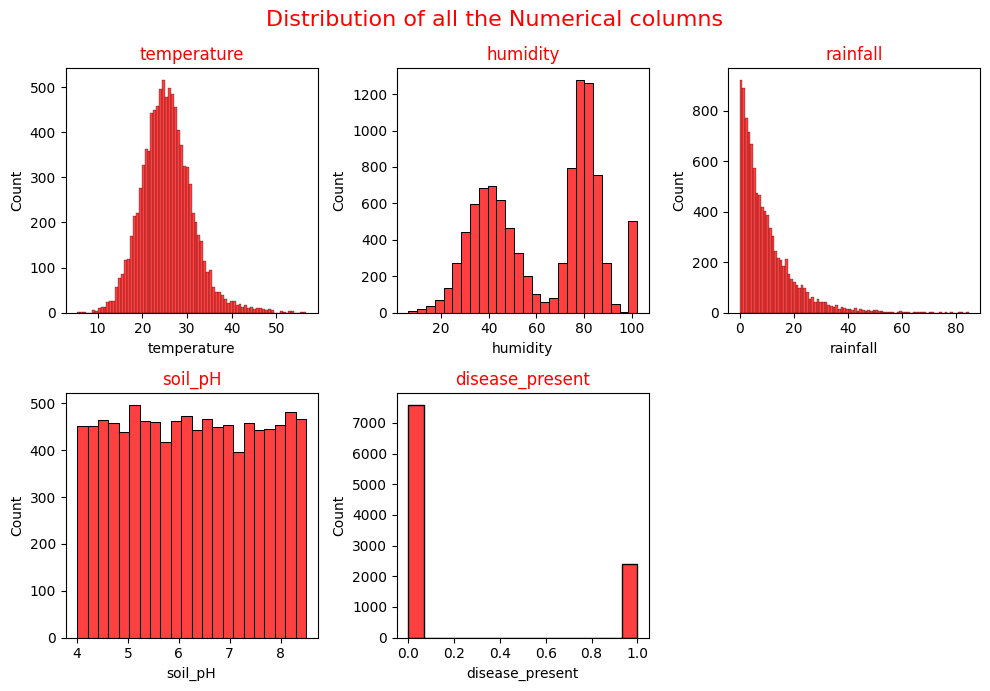

In [25]:
# Let's check the distribution of all the numerical columns
plt.figure(figsize=(10, 7))
plt.suptitle("Distribution of all the Numerical columns", size=16, color="red")
index = 0
for col in data.columns:
    index += 1
    plt.subplot(2, 3, index)
    plt.title(f"{col}", color="red")
    sns.histplot(data[col], color="red")
    plt.tight_layout()
plt.show()

* Looks like most of the columns are normally distributed except for "rainfall"